# Splitting the data into time-periods

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

master = pd.read_csv('final_data_set.csv', sep = ';', encoding = 'utf-8')

master = master.query('laureate_name!="vanvleck, jh"').copy() # Han er der 2 gange 

# Found some mistakes 
clean_dict = {'Csechoslovakia':"Czechoslovakia",
              "Irland":'Ireland',
              "Canadian":"Canada",
              "Hungaru":"Hungary",
              "Asutria":"Austria",
              'Austria-Hungary':"Austria",}
# ret fejl
master.nationality = master.nationality.apply(lambda x: clean_dict[x] if x in clean_dict.keys() else x)

master = master.dropna(subset=["laureate_name", "affiliation"]) # remove missing

In [3]:
''' Split into timeperiods - take the carreers of the nobel laurates of the 4 periods '''
first_period = master.query('prize_year <= 1939').copy()
second_period = master.query('prize_year >= 1940 and prize_year <= 1969').copy()
third_period = master.query('prize_year >= 1970 and prize_year <= 1999').copy()
fourth_period = master.query('prize_year >= 2000').copy()

In [4]:
''' Plot the top X out- and in- degree nodes '''
def plot_top_nodes(G=None, top_n = 50, hue_name = None ,hue_dict = None, title = ''):
    
    _df = pd.DataFrame(sorted(dict(G.degree()).items(), key = lambda x: x[1], reverse = True)[:top_n],
                       columns = ['Name','count'])

    _df[hue_name] = _df.Name.apply(lambda x: hue_dict[x])
    
    fig, ax = plt.subplots(figsize = (12,6))
    sns.scatterplot(data = _df, x='Name', y='count', hue = hue_name, palette = "deep",ax=ax)
    ax.set_ylabel('Degree', size = 15)
    plt.xticks(rotation=90, size = 12)
    ax.set_title(f'Distribution of degree for top {top_n} node - {title}', size = 15)
    return fig

<ipython-input-4-0aef3503f2a6>:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
<ipython-input-4-0aef3503f2a6>:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
<ipython-input-4-0aef3503f2a6>:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
<ipython-input-4-0aef3503f2a6>:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
<ipython-input-4-0aef3503f2a6>:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
<ipython-input-4-0aef3503f2a6>:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fi

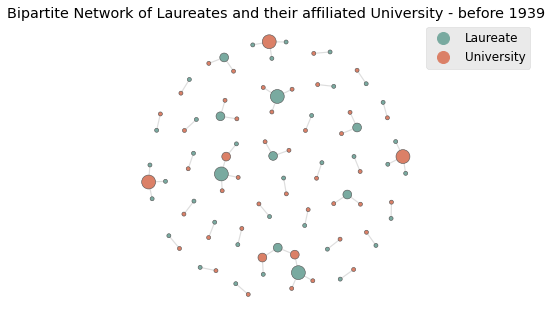

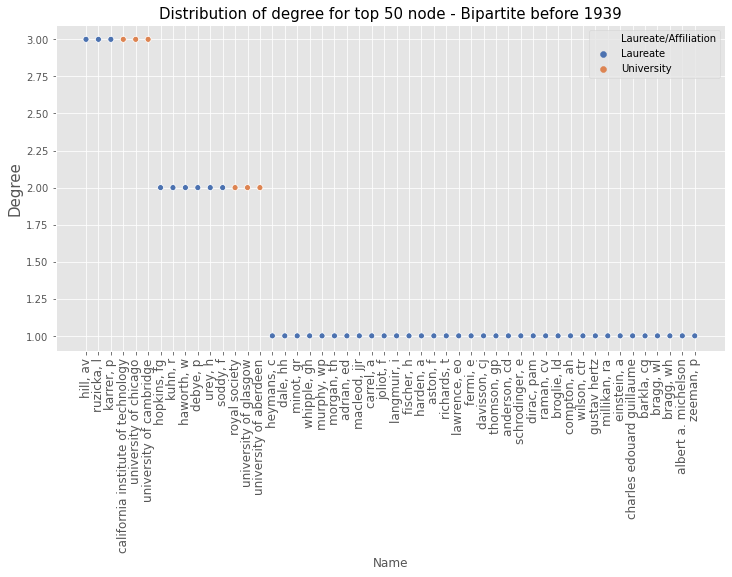

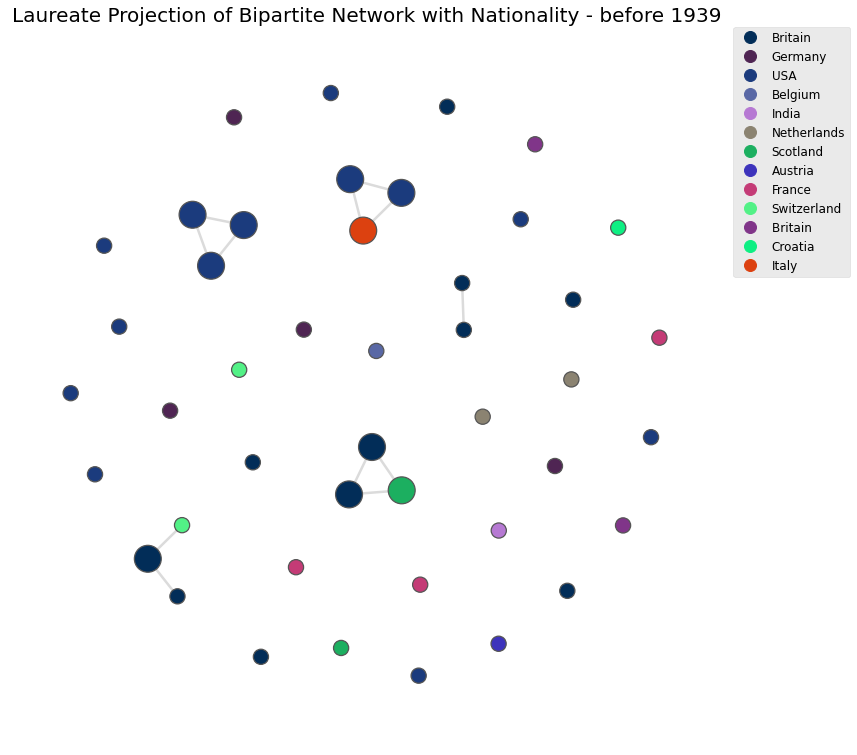

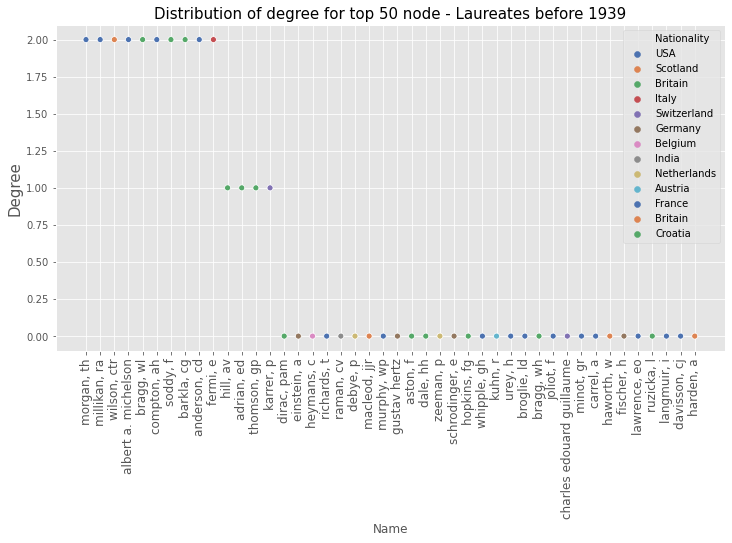

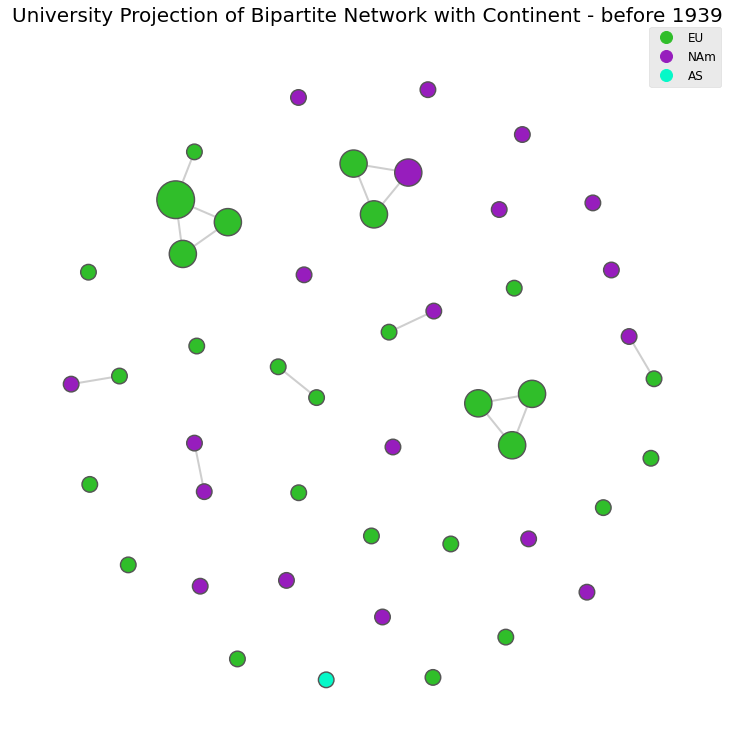

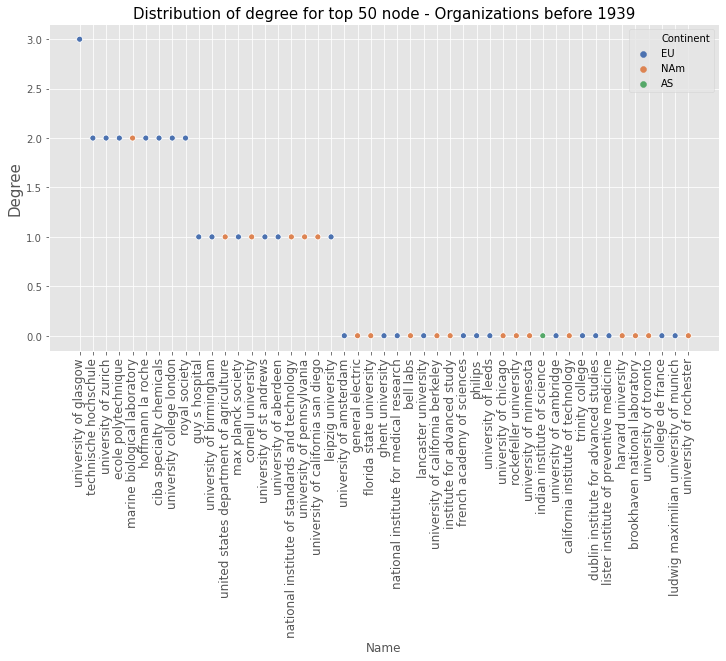

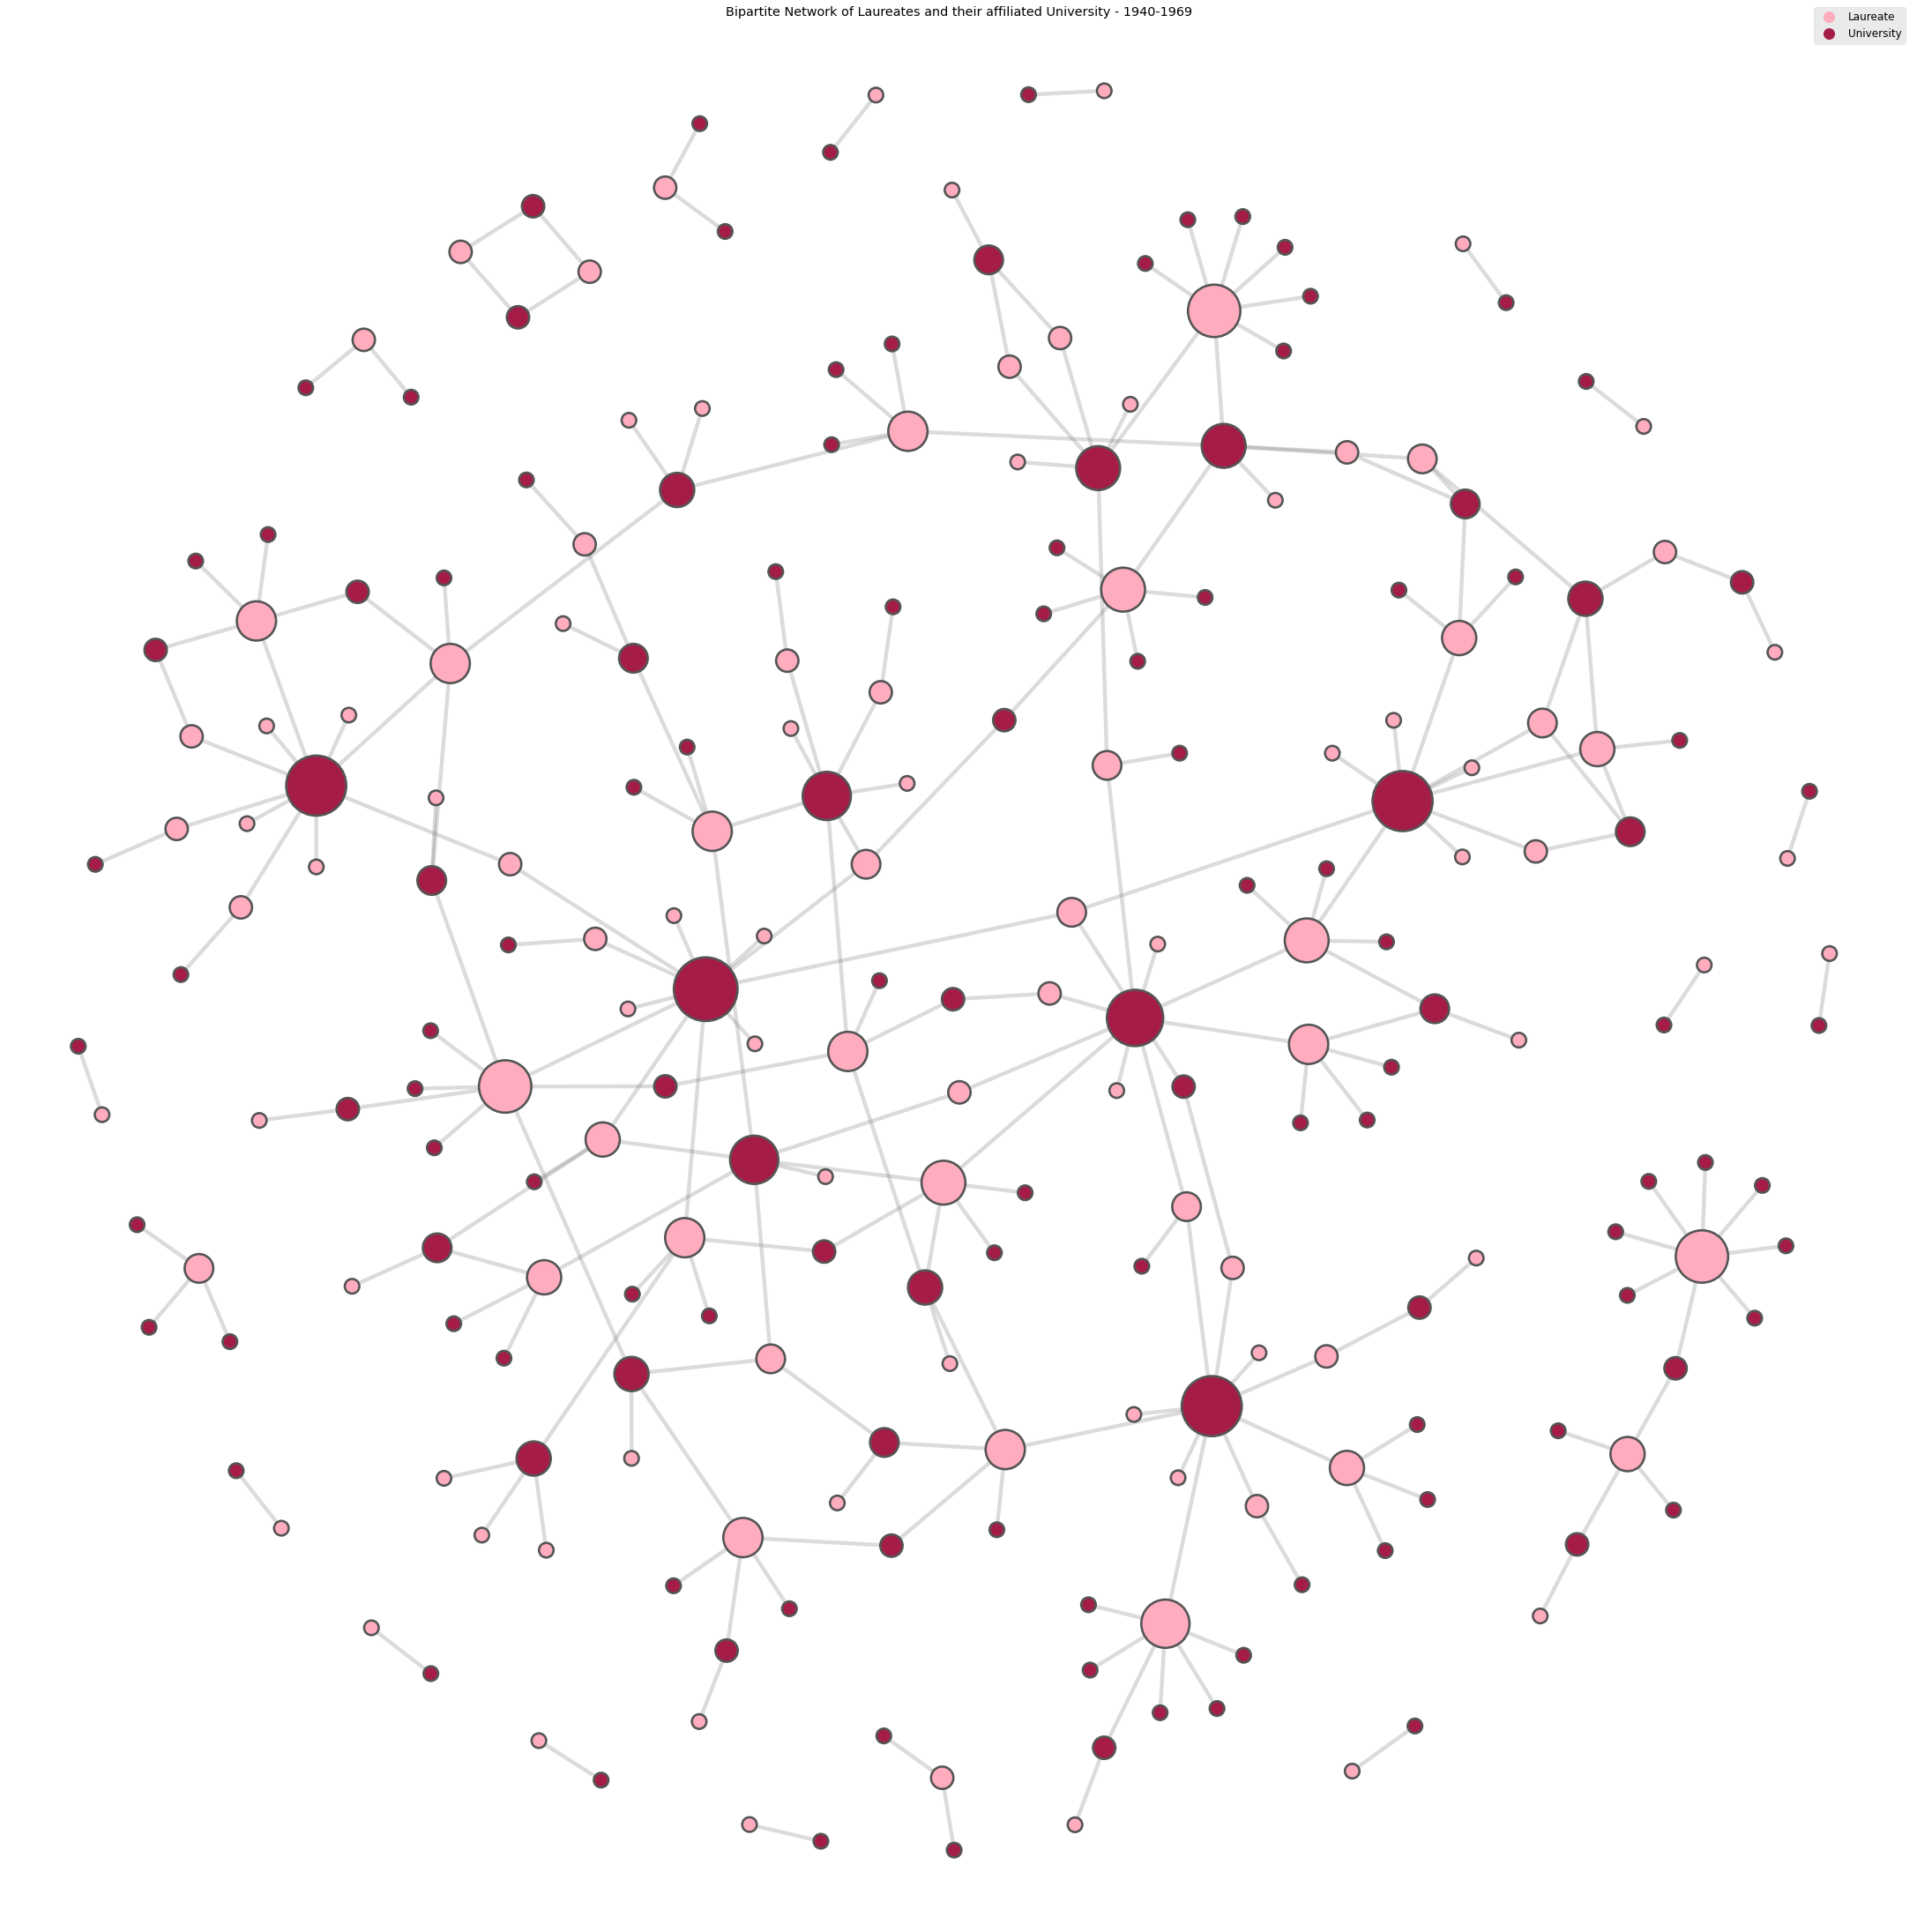

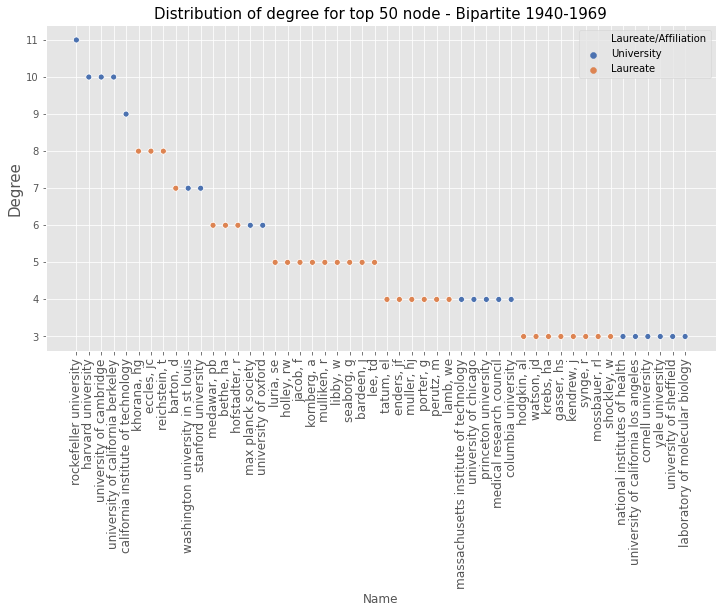

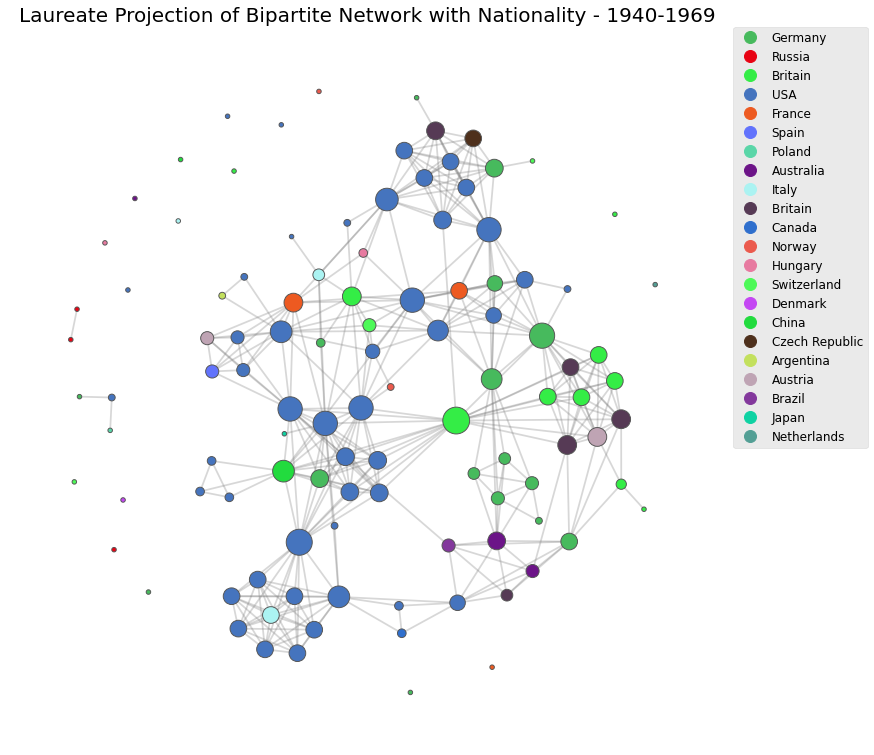

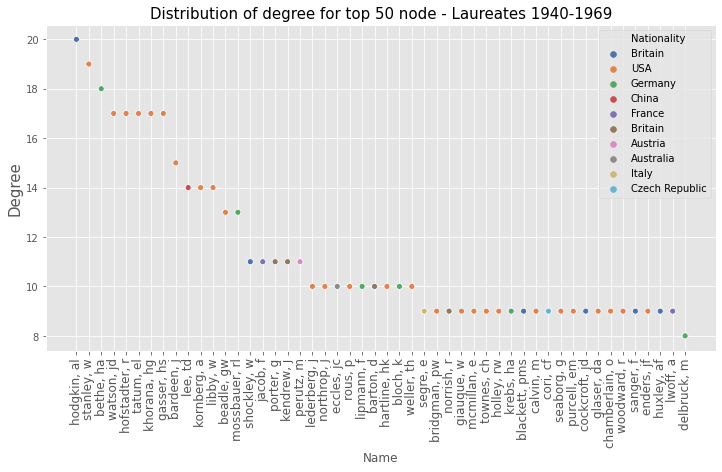

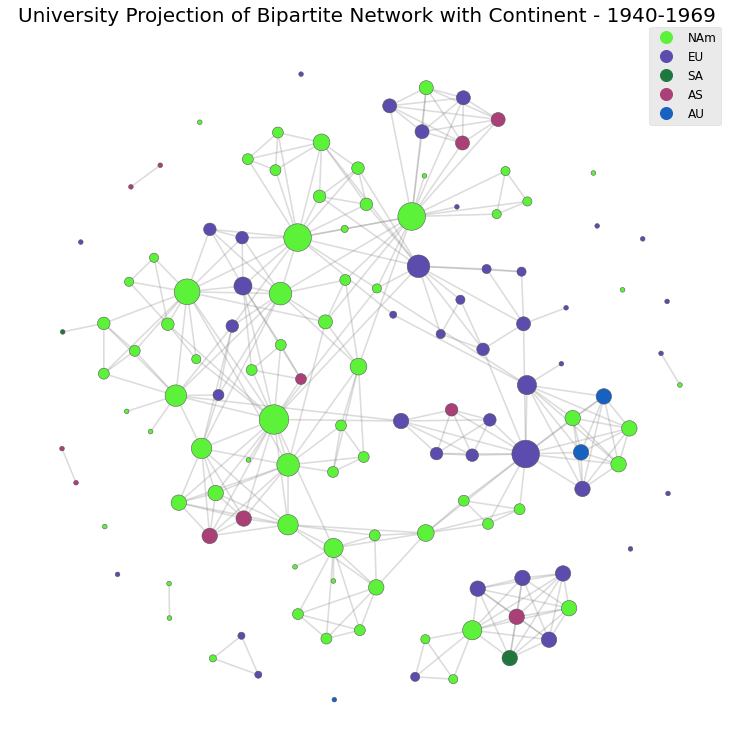

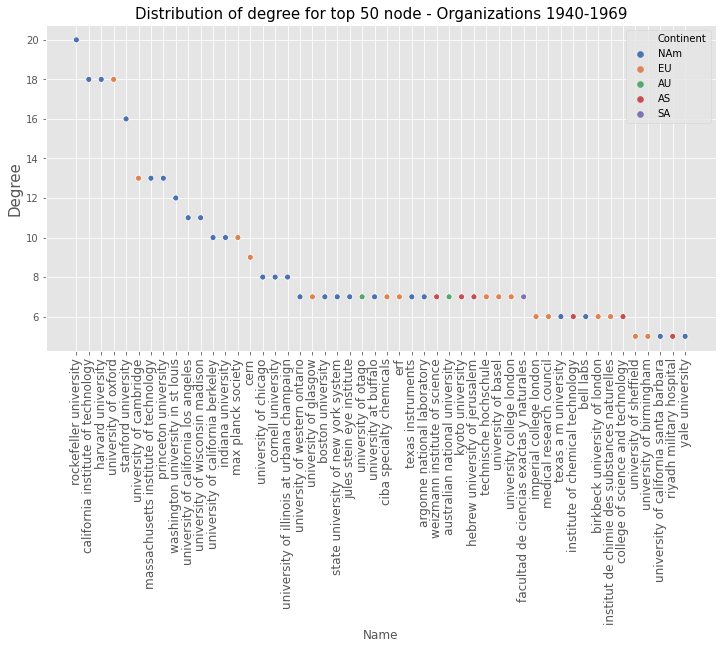

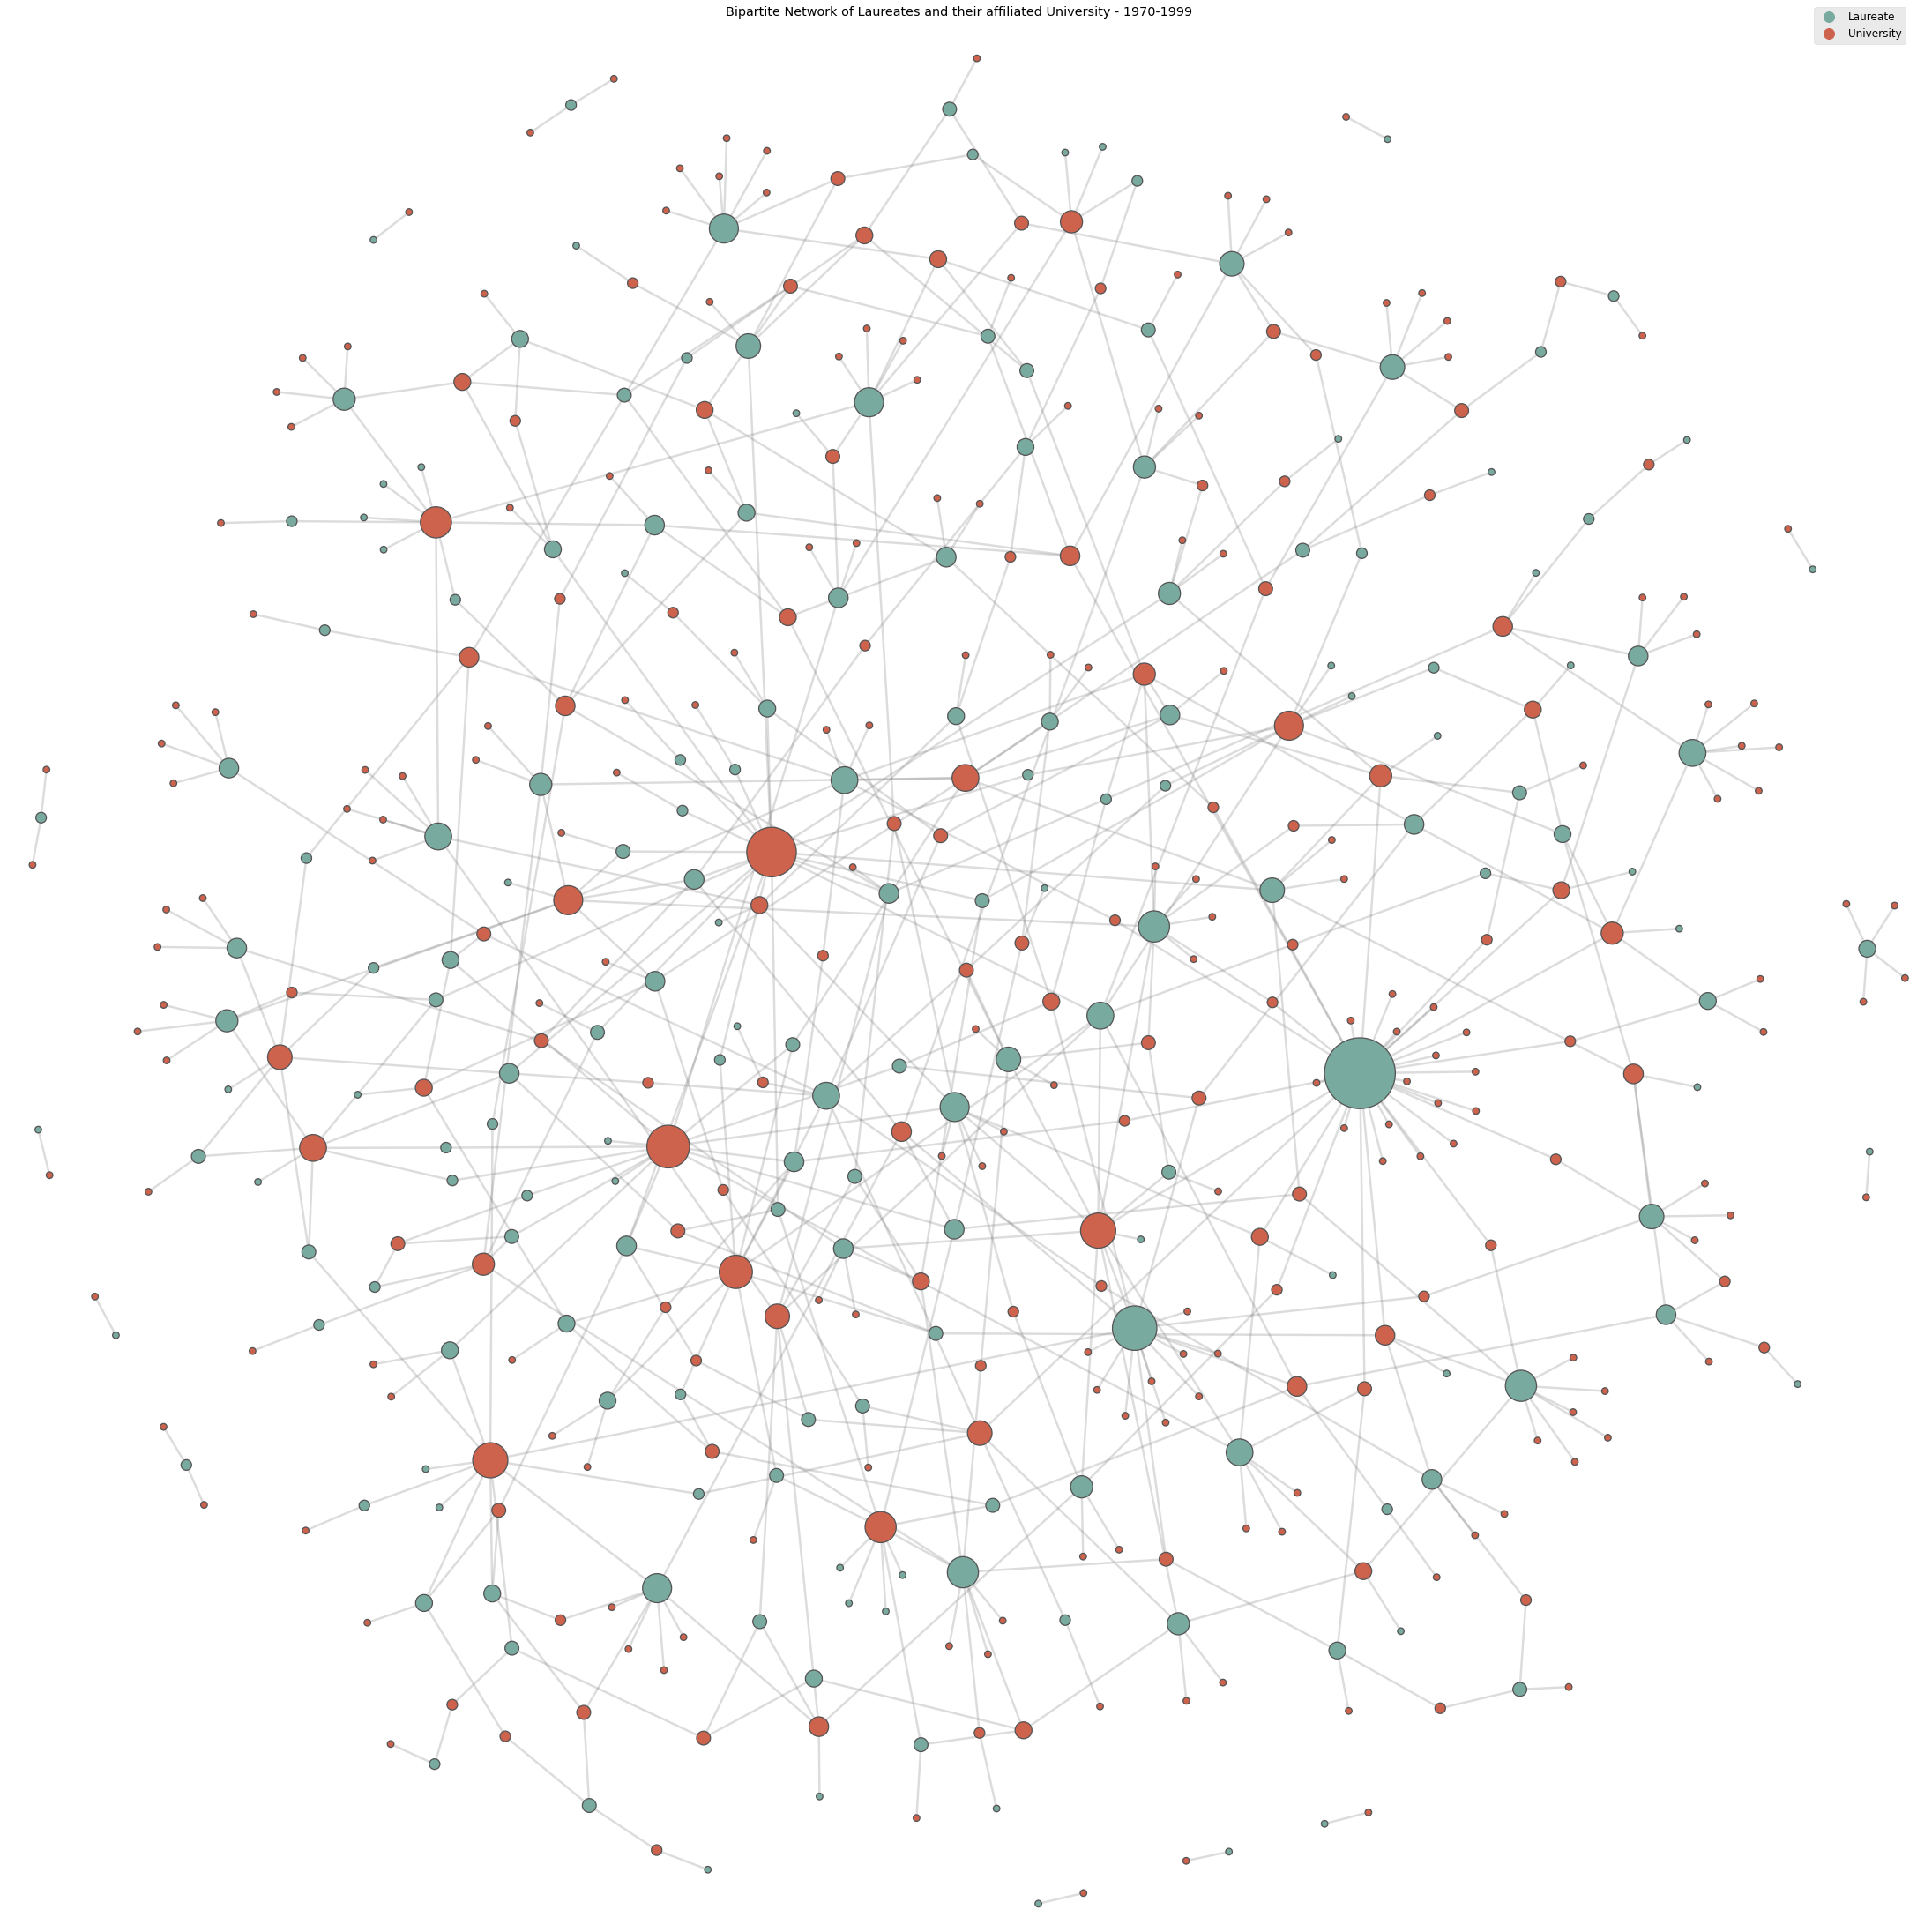

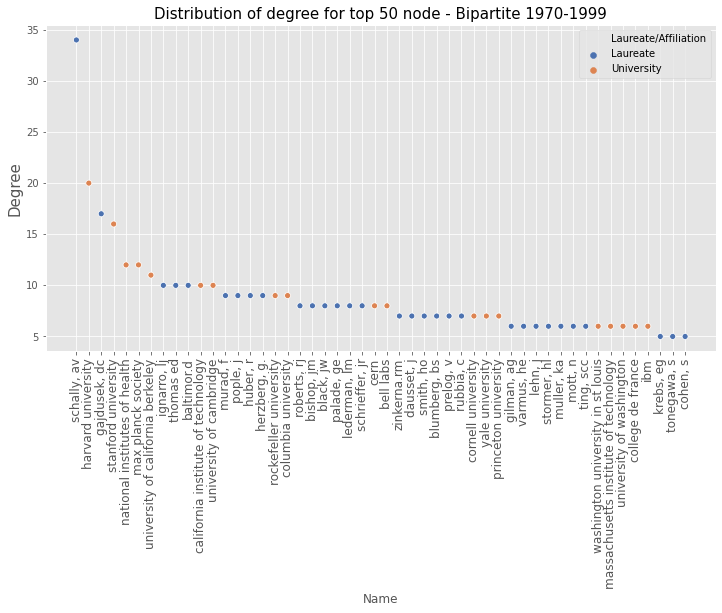

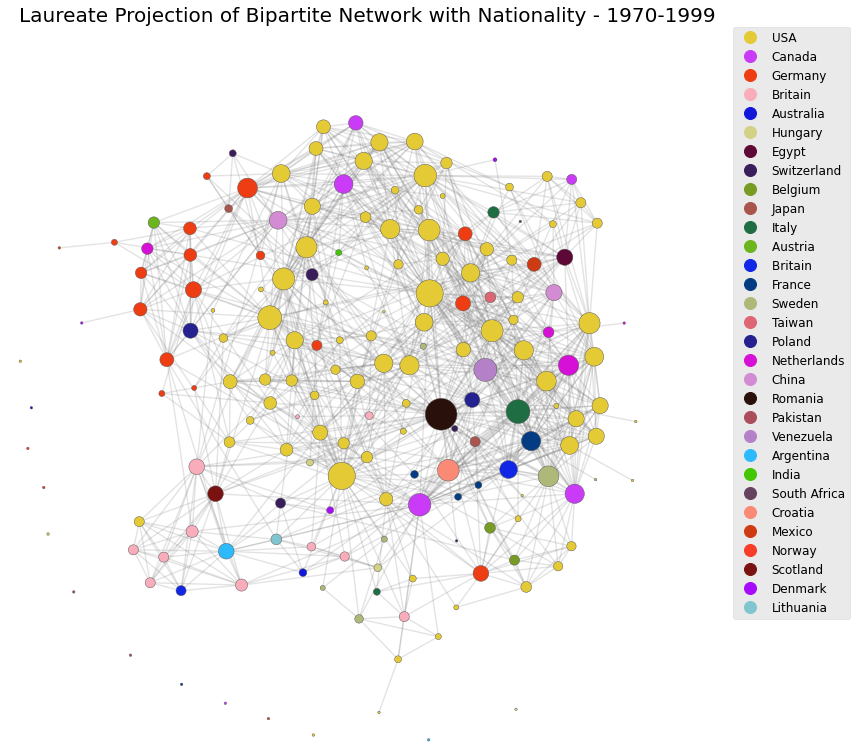

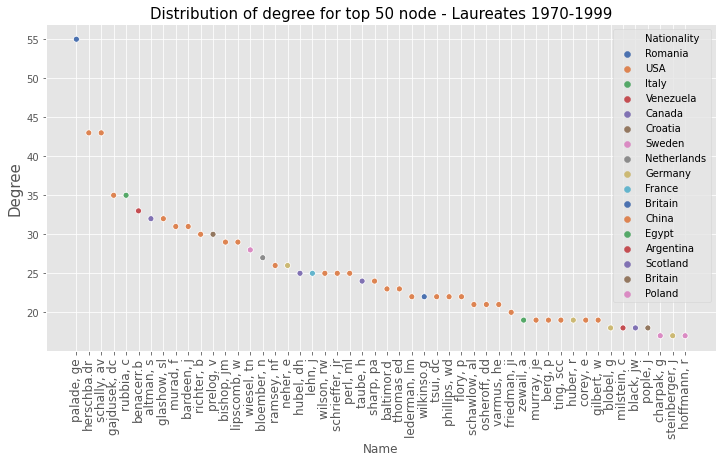

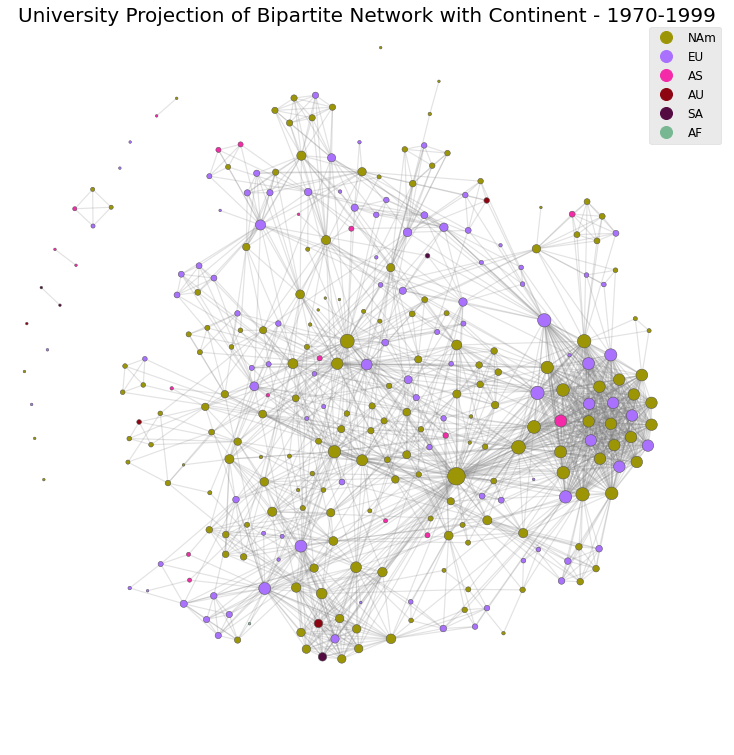

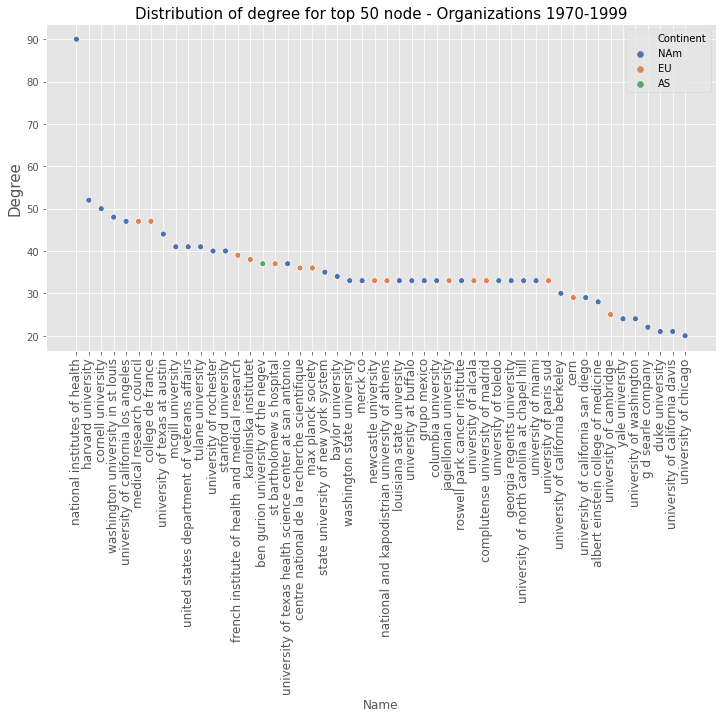

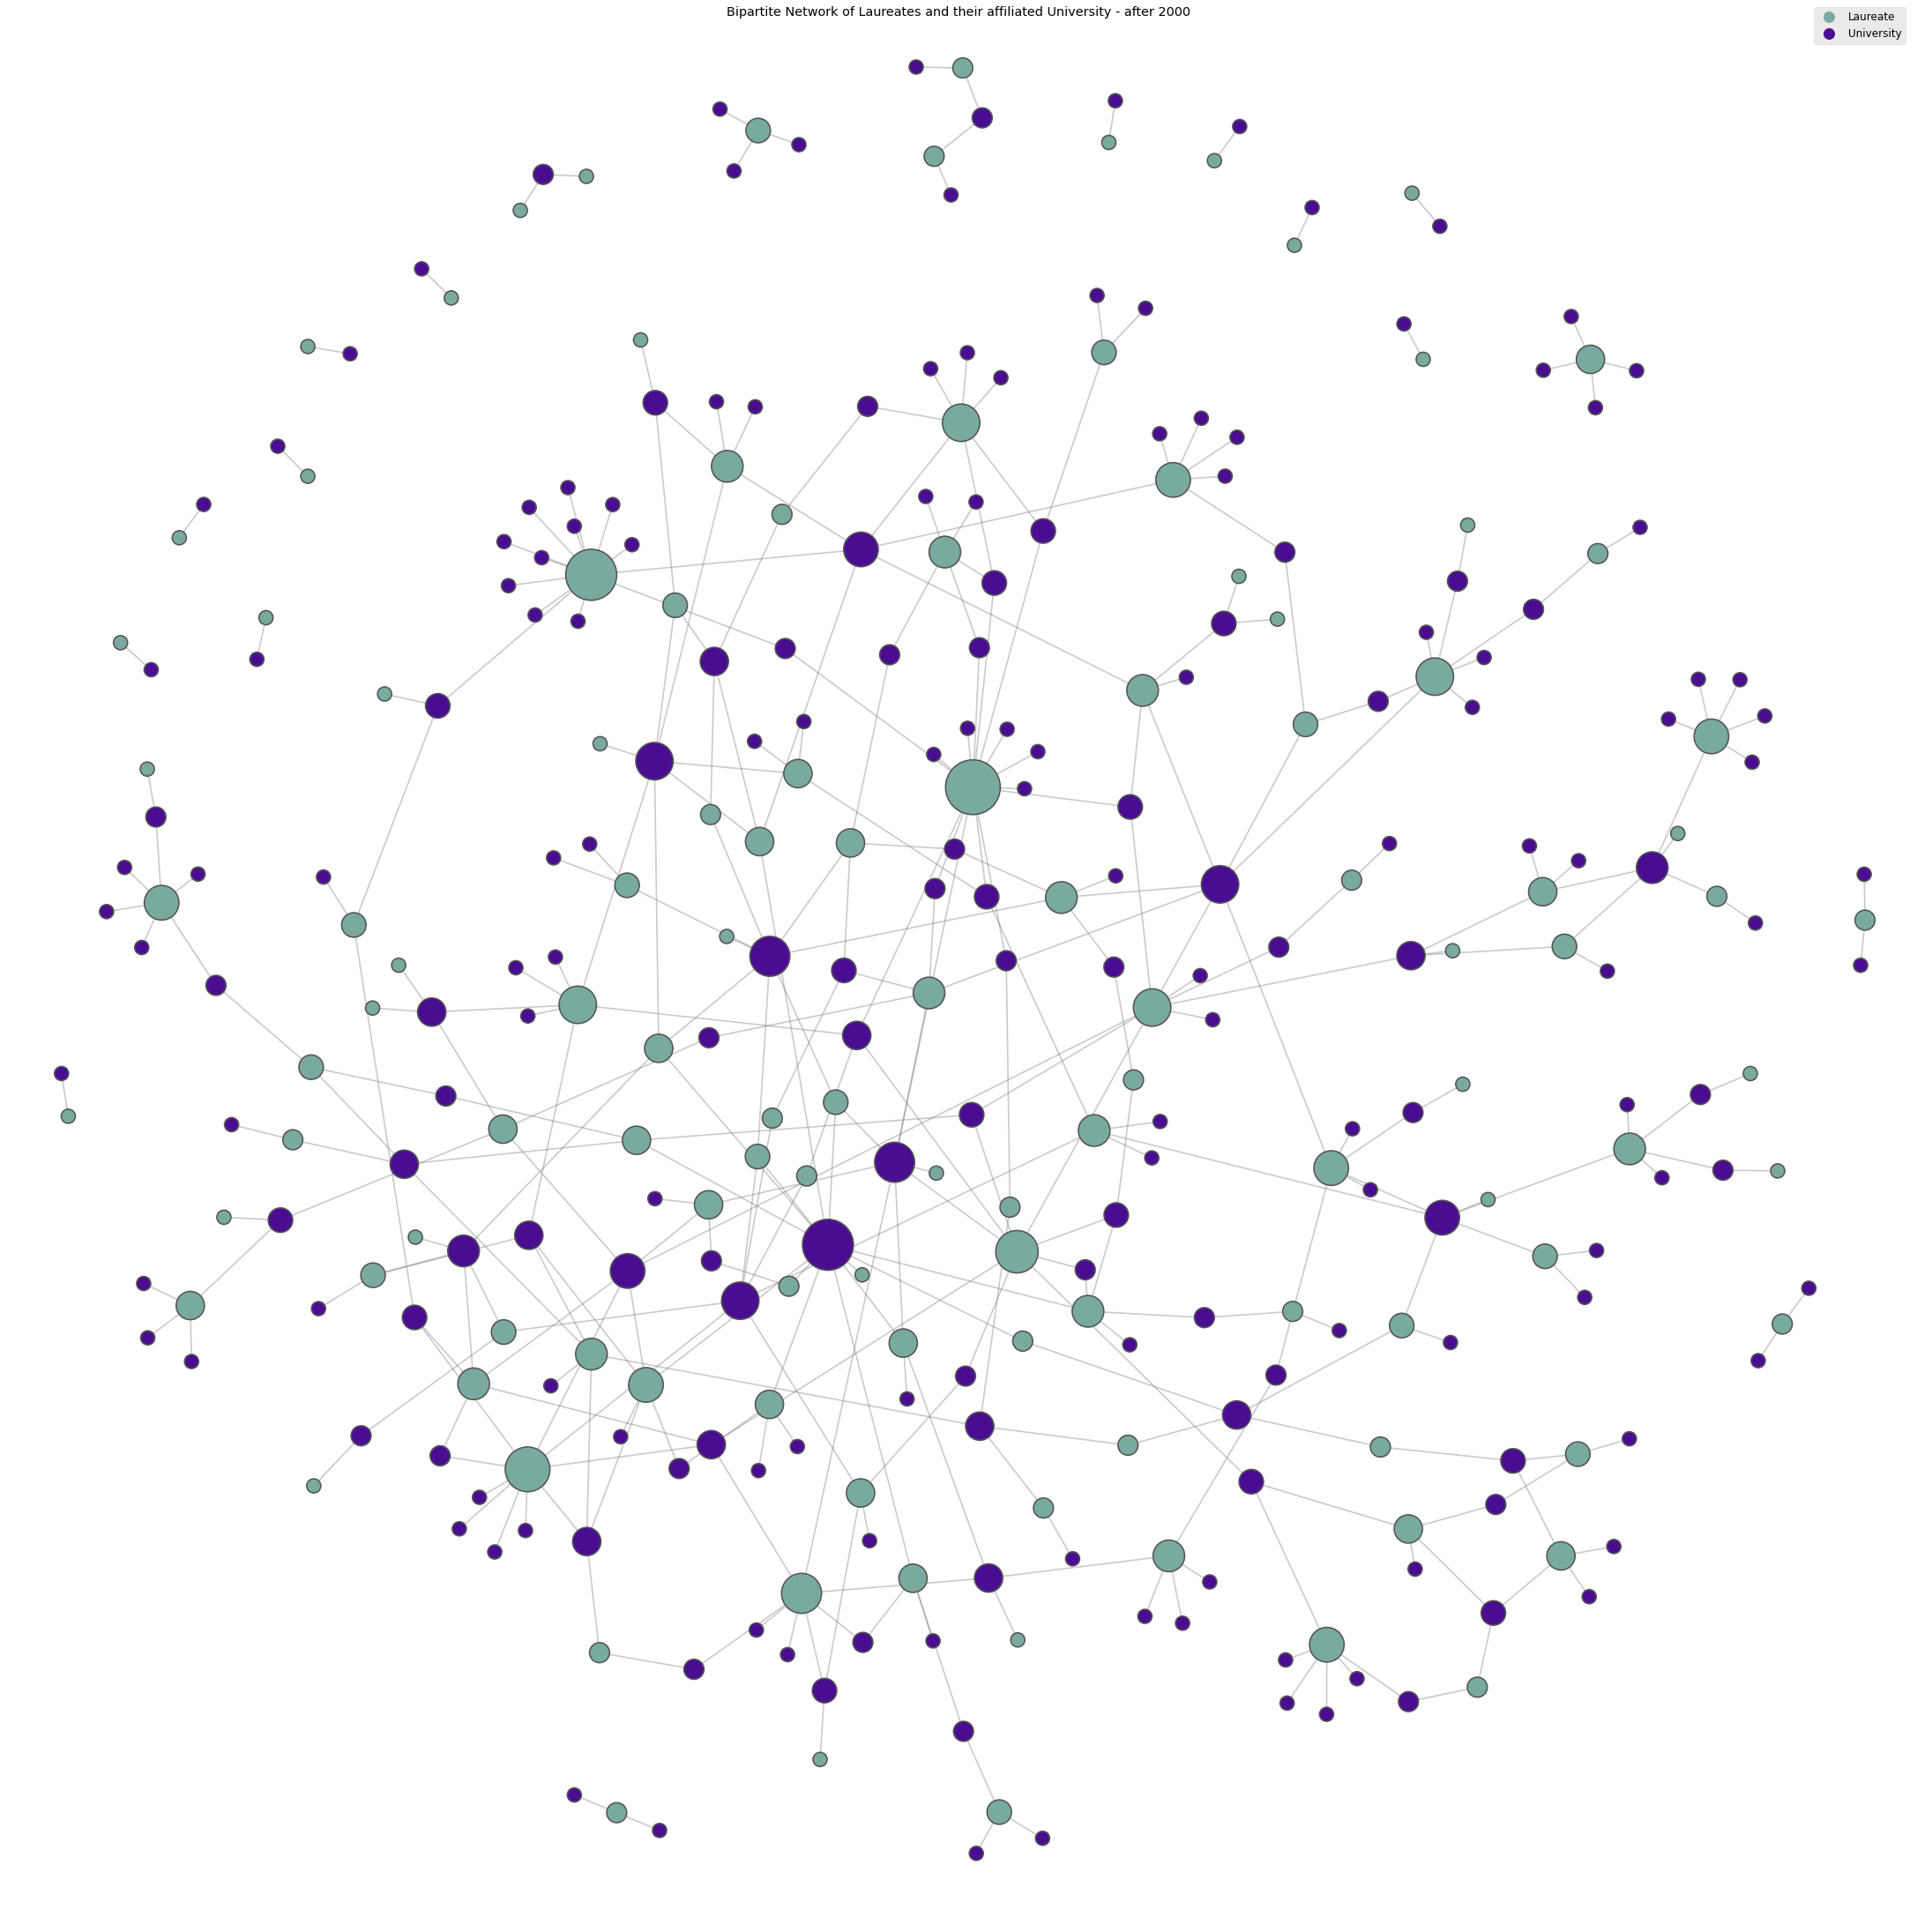

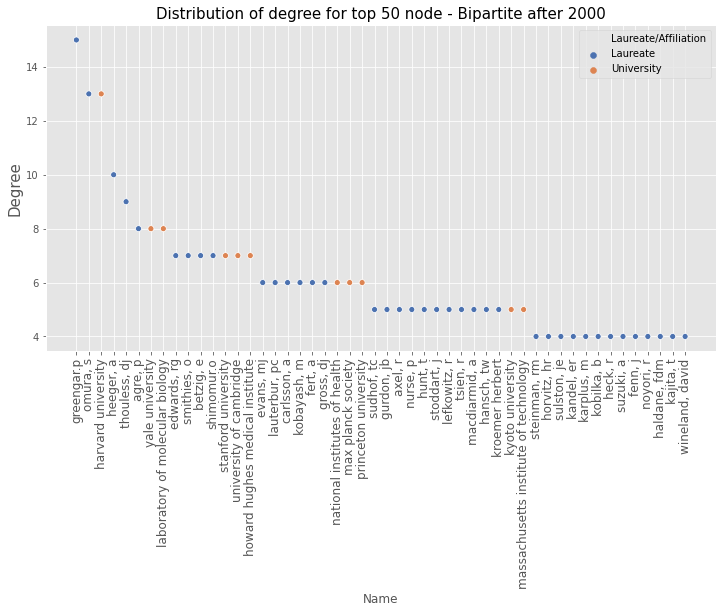

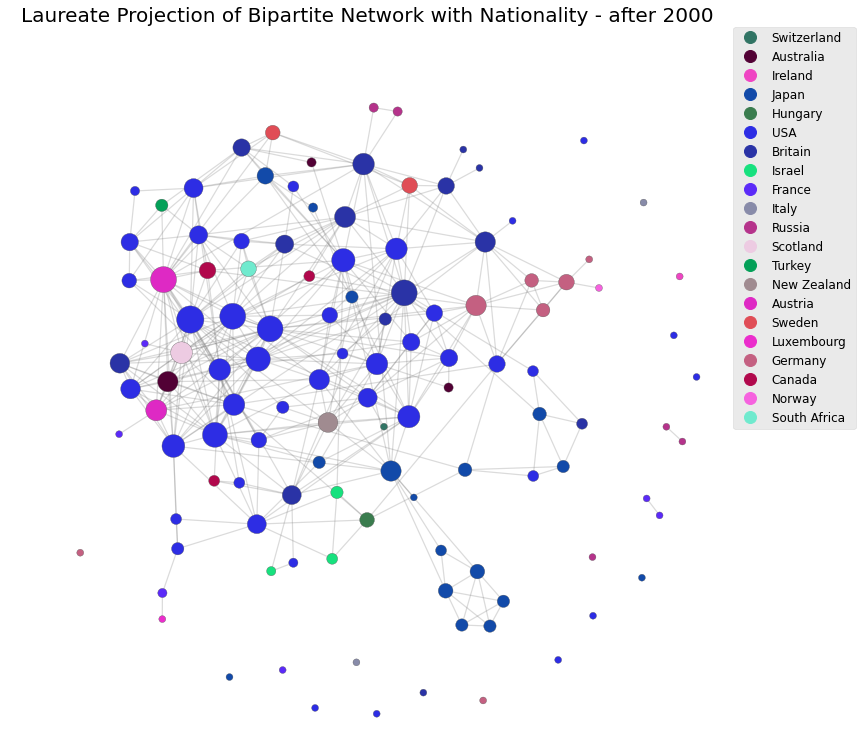

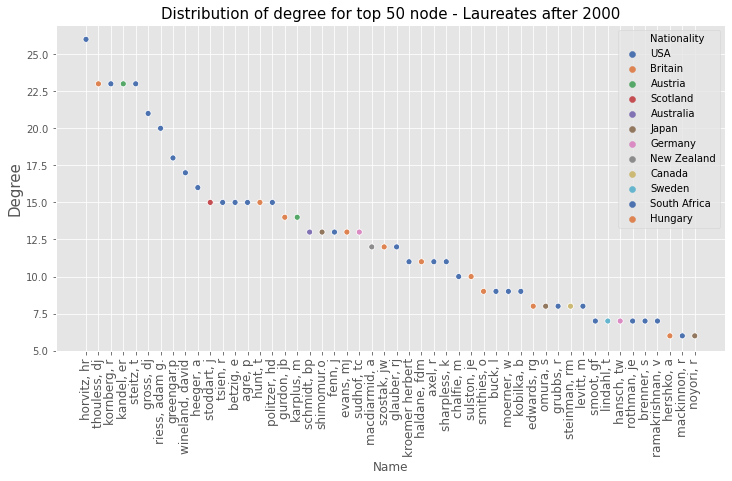

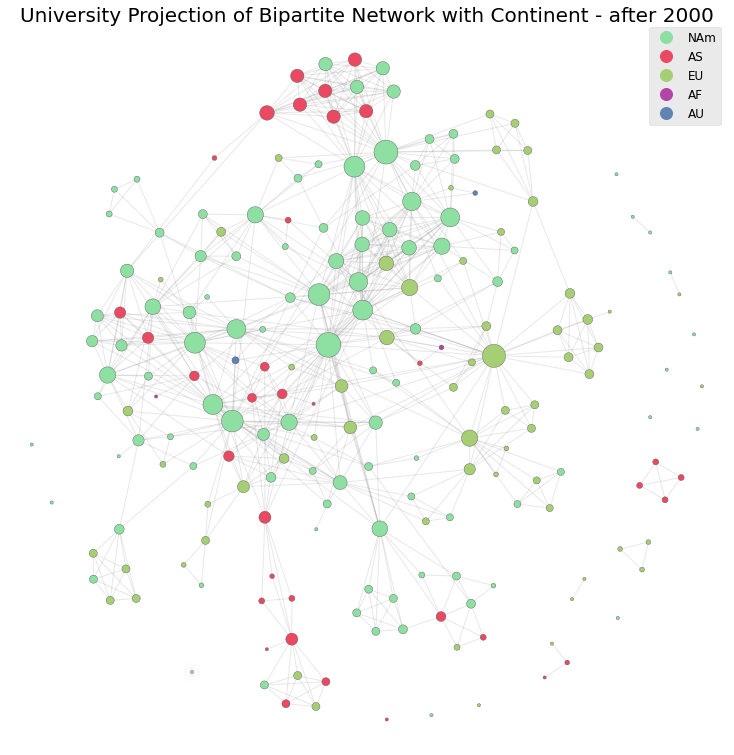

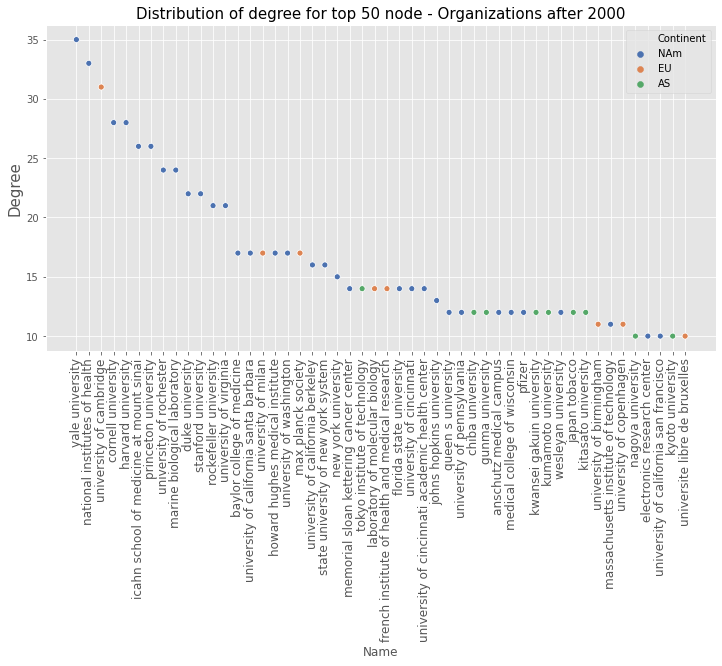

In [4]:
import networkx as nx
from networkx.algorithms import bipartite
import netwulf as nw
plt.style.use('ggplot')

for _df, _period in zip([first_period, second_period, third_period, fourth_period],
                        ['before 1939', '1940-1969', '1970-1999', 'after 2000']):
    
    ''' Create network '''
    G_bi = nx.Graph()
    G_bi.add_nodes_from(_df["laureate_name"], bipartite = 0)
    G_bi.add_nodes_from(_df["affiliation"], bipartite = 1)
    edge_list = list(_df[["laureate_name", "affiliation"]].to_records(index=False))
    G_bi.add_edges_from(edge_list)

    node_attr = {n:d["bipartite"] for n, d in G_bi.nodes(data=True)}
    nx.set_node_attributes(G_bi, node_attr, name = 'group')
    
    network, config = nw.visualize(G_bi, plot_in_cell_below=False) # Run netwulf
    # Drawing the network
    fig, ax = nw.draw_netwulf(network)
    
    ''' attribute/hue dicts '''
    laureate_dict = dict.fromkeys(_df["laureate_name"], "Laureate")
    university_dict = dict.fromkeys(_df["affiliation"], "University")
    laureate_dict.update(university_dict)
    
    # Drawing a big figure
    plt.rcParams["figure.figsize"] = (30,30)

    val_map = {laureate_dict[node['id']]:node['color'] for node in network['nodes']}
    
    ''' Den første er meget lille - derfor skal den differentiere'''
    if _period != 'before 1939':
        # Add legends
        for label in val_map.keys():
            ax.plot([],[],color=val_map[label], label=label, marker='o', linestyle="None", markersize = 25)

        # Place legend
        plt.legend(bbox_to_anchor = (1,1.01), fontsize = 30)
        ax.set_title(f'Bipartite Network of Laureates and their affiliated University - {_period}', size = 40)
    
    else: 
        # Add legends
        for label in val_map.keys():
            ax.plot([],[],color=val_map[label], label=label, marker='o', linestyle="None", markersize = 12)

        # Place legend
        plt.legend(bbox_to_anchor = (1,1.01), fontsize = 12)
        ax.set_title(f'Bipartite Network of Laureates and their affiliated University - {_period}', size = 20)
    
    # Saving as pdf
    plt.savefig(f'Plots/{_period}/bipartite_laureate_uni.', dpi=300, facecolor='w', edgecolor='w',
                bbox_inches="tight")
    
    ''' top nodes in bipartite network'''
    f = plot_top_nodes(G=G_bi,
               hue_name = 'Laureate/Affiliation',
               hue_dict = laureate_dict,
               title = f'Bipartite {_period}')

    f.savefig(f'Plots/{_period}/top_connected.', dpi=300, facecolor='w', edgecolor='w',
             bbox_inches="tight")
    
    #### Split into projections ####
    top_nodes = {n for n, d in G_bi.nodes(data=True) if d["bipartite"] == 0} # Laureates 
    bottom_nodes = set(G_bi) - top_nodes

    ## Projections 
    G_top_pro = bipartite.projection.projected_graph(G_bi, top_nodes) # laureates 
    G_bottom_pro = bipartite.projection.projected_graph(G_bi, bottom_nodes) # affiliation 
    
    ''' Nationality hue for laureates '''
    _df.nationality = _df.nationality.apply(lambda x: x.split(',')[0])
    name_nat_dict = {name:nat for name, nat in zip(_df.laureate_name, _df.nationality)}
    
    # Assign communty labels
    nx.set_node_attributes(G_top_pro, name_nat_dict, 'group')
    #Use netwulf to visualize
    network, config = nw.visualize(G_top_pro, plot_in_cell_below=False)
    
    fig, ax = nw.draw_netwulf(network, figsize = 10)
    ax.set_title(f'Laureate Projection of Bipartite Network with Nationality - {_period}', size = 20)

    # Drawing a big figure
    plt.rcParams["figure.figsize"] = (30,30)

    val_map = {name_nat_dict[node['id']]:node['color'] for node in network['nodes']}

    # Add legends
    for label in val_map.keys():
        ax.plot([],[],color=val_map[label], label=label, marker='o', linestyle="None", markersize = 12)
    # Place legend
    plt.legend(bbox_to_anchor = (1,1.01), fontsize = 12)
    # Saving as pdf
    fig.tight_layout()
    plt.savefig(f'Plots/{_period}/laureate_projection_nationality.png', dpi=300, bbox_inches='tight')
    
    ''' Top Laureate nodes with nationality as Hue '''
    f = plot_top_nodes(G=G_top_pro,
                   hue_name = 'Nationality',
                   hue_dict = name_nat_dict,
                   title = f"Laureates {_period}")

    f.savefig(f'Plots/{_period}/top_connected_laureate_bipart.png', dpi=300, facecolor='w', edgecolor='w',
             bbox_inches="tight")
    
    ''' Continent hue for organization ''' 
    cont_dict = _df.set_index('affiliation')['continent'].to_dict()
    _continent = {n:cont_dict[n] if pd.isna(cont_dict[n])==False else 'NAm' for n in G_bottom_pro.nodes()}
    
    
    # Assign communty labels
    nx.set_node_attributes(G_bottom_pro, _continent, 'group')
    #Use netwulf to visualize
    network, config = nw.visualize(G_bottom_pro, plot_in_cell_below=False)
    
    fig, ax = nw.draw_netwulf(network, figsize = 10)
    ax.set_title(f'University Projection of Bipartite Network with Continent - {_period}', size = 20)

    # Drawing a big figure
    plt.rcParams["figure.figsize"] = (30,30)

    val_map = {_continent[node['id']]:node['color'] for node in network['nodes']}

    # Add legends
    for label in val_map.keys():
        ax.plot([],[],color=val_map[label], label=label, marker='o', linestyle="None", markersize = 12)
        
    # Place legend
    plt.legend(bbox_to_anchor = (1,1.01), fontsize = 12)
    # Saving as pdf
    fig.tight_layout()
    plt.savefig(f'Plots/{_period}/university_projection_continent.png', dpi=300, bbox_inches='tight')
    
    ''' Top organization nodes with nationality as Hue '''
    f = plot_top_nodes(G=G_bottom_pro,
                   hue_name = 'Continent',
                   hue_dict = _continent,
                   title = f"Organizations {_period}")

    # Saving as pdf
    f.savefig(f'Plots/{_period}/top_connected_university_bipart.png', dpi=300, facecolor='w', edgecolor='w',
             bbox_inches="tight")